In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from scipy.stats import spearmanr
import re
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
concentrations = {
    'c1': 10e-6,
    'c2': 3e-6,
    'c3': 1e-6,
}
concentrations.update({'LC': min(concentrations.values()) / 1e3})
concentrations_log10 = {k: np.log10(v) for k, v in concentrations.items()}
concentrations_log10

{'c1': -5.0, 'c2': -5.522878745280337, 'c3': -6.0, 'LC': -9.0}

In [3]:
def read_data(compound='TI26', assay='TNF'):
    bname = '../../resources/cell-based-assays/Tina-email-2023-08-31/'
    fpath = bname + compound + '_' + assay + '.txt'
    data = pd.read_csv(fpath, sep='\t')
    return(data)

data = read_data(compound='TI26', assay='TNF')
data

,VC,c1,c2,c3,RI,LC
0,0.917858,0.755247,9.443050,36.121420,1.403177,13.312150
1,1.303890,7.497930,11.304590,1.577535,0.268734,2.062547
2,0.706698,0.442091,12.486180,28.991770,0.276541,1.752594
3,0.771455,0.958683,4.763406,17.613260,0.812029,1.262600
4,0.394515,0.909701,4.902034,1.180168,0.191152,0.593902
5,0.489854,1.303890,3.428685,8.875549,1.594178,51.612920


In [4]:
def reshape_data(data):
    df = data[concentrations.keys()].stack().to_frame('readout')
    df['conc'] = [concentrations[c] for c in df.index.get_level_values(1)]
    df['conc_log10'] = [concentrations_log10[c] for c in df.index.get_level_values(1)]
    return(df)

data_reshaped = reshape_data(read_data(compound='TI26', assay='TNF'))
data_reshaped

readout          conc  conc_log10
0 c1   0.755247  1.000000e-05   -5.000000
  c2   9.443050  3.000000e-06   -5.522879
  c3  36.121420  1.000000e-06   -6.000000
  LC  13.312150  1.000000e-09   -9.000000
1 c1   7.497930  1.000000e-05   -5.000000
  c2  11.304590  3.000000e-06   -5.522879
  c3   1.577535  1.000000e-06   -6.000000
  LC   2.062547  1.000000e-09   -9.000000
2 c1   0.442091  1.000000e-05   -5.000000
  c2  12.486180  3.000000e-06   -5.522879
  c3  28.991770  1.000000e-06   -6.000000
  LC   1.752594  1.000000e-09   -9.000000
3 c1   0.958683  1.000000e-05   -5.000000
  c2   4.763406  3.000000e-06   -5.522879
  c3  17.613260  1.000000e-06   -6.000000
  LC   1.262600  1.000000e-09   -9.000000
4 c1   0.909701  1.000000e-05   -5.000000
  c2   4.902034  3.000000e-06   -5.522879
  c3   1.180168  1.000000e-06   -6.000000
  LC   0.593902  1.000000e-09   -9.000000
5 c1   1.303890  1.000000e-05   -5.000000
  c2   3.428685  3.000000e-06   -5.522879
  c3   8.875549  1.000000e-06   -6.000000
  LC  51.612920  1.000000e-09   -9.000000

## Spearman correlation: conc vs readout

In [5]:
spearmanr(data_reshaped.drop('conc', axis=1).drop('LC', axis=0, level=1))

SignificanceResult(statistic=-0.6295115802917071, pvalue=0.005119517643890959)

In [6]:
n_chains = 4
my_random_seed = 1949

def sample_linear_1(y_obs, x_obs):
    mymodel = pm.Model()
    with mymodel:
        σ = pm.HalfStudentT("σ", 20, 100)
        β_0 = pm.Normal("β_0", mu=0, sigma=20)
        β_1 = pm.Normal("β_1", mu=0, sigma=10)
        μ = pm.Deterministic("μ", β_0 + β_1 * x_obs)
        y = pm.Normal("y", mu=μ, sigma=σ, observed=y_obs)
        mcmc = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=[my_random_seed] * n_chains)
        return((mcmc, mymodel))

def sample_sigmoid_1(y_obs, x_obs):
    mymodel = pm.Model()
    with mymodel:
        EC_50_mu = np.quantile(x_obs, 0.5) # originally -5.5, TI26 TNFα
        EC_50 = pm.Normal('EC_50', EC_50_mu, 0.5)
        y_0_alpha = np.quantile(y_obs, 0.9) # originally 20, TI26 TNFα
        y_0 = pm.Gamma('y_0', y_0_alpha, 1)
        Δ_pct = pm.Gamma('Δ_pct', 2, 2)
        y_1 = pm.Deterministic('y_1', Δ_pct * y_0)
        k = pm.HalfStudentT("k", nu=1, sigma=1)
        σ = pm.HalfStudentT("σ", nu=20, sigma=100)
        μ = pm.Deterministic("μ", y_1 + (y_0 - y_1) / (1 + np.exp(k * (x_obs - EC_50))))
        y = pm.Normal("y", mu=μ, sigma=σ, observed=y_obs)
        mcmc = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=[my_random_seed] * n_chains)
        return((mcmc, mymodel))

def sample_sigmoid_2(y_obs, x_obs):
    mymodel = pm.Model()
    with mymodel:
        EC_50_mu = np.quantile(x_obs, 0.5) # originally -5.5, TI26 TNFα
        EC_50 = pm.Normal('EC_50', EC_50_mu, 0.5)
        y_0_alpha = np.quantile(y_obs, 0.9) # originally 20, TI26 TNFα
        y_0 = pm.Gamma('y_0', y_0_alpha, 1)
        Δ_pct = pm.Gamma('Δ_pct', 2, 2)
        y_1 = pm.Deterministic('y_1', Δ_pct * y_0)
        k = pm.HalfStudentT("k", nu=1, sigma=1)
        μ = pm.Deterministic("μ", abs(y_1 + (y_0 - y_1) / (1 + np.exp(k * (x_obs - EC_50)))))
        σ = pm.HalfStudentT("σ", 20, 100)
        σ_y = pm.Deterministic("σ_y", σ * μ / 10)
        y = pm.Normal("y", mu=μ, sigma=σ_y, observed=y_obs)
        mcmc = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=[my_random_seed] * n_chains)
        return((mcmc, mymodel))

def sample_sigmoid_3(y_obs, x_obs):
    mymodel = pm.Model()
    with mymodel:
        EC_50_mu = np.quantile(x_obs, 0.5) # originally -5.5, TI26 TNFα
        EC_50 = pm.Normal('EC_50', EC_50_mu, 0.5)
        y_0_alpha = np.quantile(y_obs, 0.9) # originally 20, TI26 TNFα
        y_0 = pm.Gamma('y_0', y_0_alpha, 1)
        Δ_pct = pm.Gamma('Δ_pct', 2, 2)
        y_1 = pm.Deterministic('y_1', Δ_pct * y_0)
        k = pm.HalfStudentT("k", nu=1, sigma=1)
        μ = pm.Deterministic("μ", abs(y_1 + (y_0 - y_1) / (1 + np.exp(k * (x_obs - EC_50)))))
        α = pm.HalfStudentT("α", nu=1, sigma=1)
        β = pm.HalfStudentT("β", nu=1, sigma=1)
        y = pm.Gamma('y', alpha=α * μ, beta=β, observed=y_obs)
        mcmc = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=[my_random_seed] * n_chains)
        return((mcmc, mymodel))

def sample_sigmoid_4(y_obs, x_obs):
    mymodel = pm.Model()
    with mymodel:
        EC_50_mu = np.quantile(x_obs, 0.5) # originally -5.5, TI26 TNFα
        EC_50 = pm.Normal('EC_50', EC_50_mu, 0.5)
        y_0_alpha = np.quantile(y_obs, 0.9) # originally 20, TI26 TNFα
        y_0 = pm.Gamma('y_0', y_0_alpha, 1)
        Δ_pct = pm.Gamma('Δ_pct', 2, 2)
        y_1 = pm.Deterministic('y_1', Δ_pct * y_0)
        k = pm.HalfStudentT("k", nu=1, sigma=1)
        μ = pm.Deterministic("μ", abs(y_1 + (y_0 - y_1) / (1 + np.exp(k * (x_obs - EC_50)))))
        α = pm.HalfStudentT("α", nu=1, sigma=1)
        β = pm.HalfStudentT("β", nu=1, sigma=1)
        y = pm.Gamma('y', alpha=α, beta=β / μ, observed=y_obs)
        mcmc = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=[my_random_seed] * n_chains)
        return((mcmc, mymodel))
'''
def sample_sigmoid_5(y_obs, x_obs):
    mymodel = pm.Model()
    with mymodel:
        EC_50_mu = np.quantile(x_obs, 0.5) # originally -5.5, TI26 TNFα
        EC_50 = pm.Normal('EC_50', EC_50_mu, 0.5)
        y_0_alpha = np.quantile(y_obs, 0.9) # originally 20, TI26 TNFα
        y_0 = pm.Gamma('y_0', y_0_alpha, 1)
        Δ_pct = pm.Gamma('Δ_pct', 2, 2)
        y_1 = pm.Deterministic('y_1', Δ_pct * y_0)
        k = pm.HalfStudentT("k", nu=1, sigma=1)
        μ = pm.Deterministic("μ", abs(y_1 + (y_0 - y_1) / (1 + np.exp(k * (x_obs - EC_50)))))
        α = pm.HalfStudentT("α", nu=1, sigma=1)
        β = pm.HalfStudentT("β", nu=1, sigma=1)
        y = pm.Gamma('y', alpha=α, beta=β / μ, observed=y_obs)
        mcmc = pm.sample(return_inferencedata=True, idata_kwargs={'log_likelihood': True}, random_seed=[my_random_seed] * n_chains)
        return((mcmc, mymodel))
'''

my_models = {
    'linear 1': sample_linear_1,
    'sigmoid 1': sample_sigmoid_1,
    'sigmoid 2': sample_sigmoid_2,
    'sigmoid 3': sample_sigmoid_3,
    'sigmoid 4': sample_sigmoid_4,
}

In [7]:
data_reshaped = reshape_data(read_data(compound='TI26', assay='TNF'))
x_obs = data_reshaped['conc_log10'].values
y_obs = data_reshaped['readout'].values

idata = {name: model(y_obs, x_obs) for name, model in my_models.items()}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, Δ_pct, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, Δ_pct, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, Δ_pct, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, Δ_pct, k, α, β]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [8]:
for model in my_models.keys():
    pm.model_to_graphviz(idata[model][1])

In [9]:
az.compare({k: v[0] for k, v in idata.items()})

/Users/jonesa7/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
sigmoid 4,0,-77.267356,2.547340,0.000000,9.519994e-01,6.470420,0.000000,True,log
sigmoid 3,1,-78.600127,2.433531,1.332771,0.000000e+00,6.881998,0.821988,False,log
sigmoid 2,2,-87.088549,4.016062,9.821193,4.800056e-02,4.576177,4.921490,True,log
sigmoid 1,3,-97.818899,3.038969,20.551543,0.000000e+00,4.538295,4.831210,False,log
linear 1,4,-98.813446,4.646072,21.546090,5.709877e-13,6.621051,4.542150,False,log


In [10]:
ssize = 1000
prior_samples = {m: pm.sample_prior_predictive(model=idata[m][1], samples=ssize) for m in idata.keys()}

Sampling: [y, β_0, β_1, σ]
Sampling: [EC_50, k, y, y_0, Δ_pct, σ]
Sampling: [EC_50, k, y, y_0, Δ_pct, σ]
Sampling: [EC_50, k, y, y_0, Δ_pct, α, β]
Sampling: [EC_50, k, y, y_0, Δ_pct, α, β]


In [11]:
posterior_samples = {m: pm.sample_posterior_predictive(idata[m][0], model=idata[m][1]) for m in idata.keys()}

Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


In [12]:
def plot_sampled_curves_linear_1(ax, data=prior_samples['linear 1'].prior, data_reshaped=data_reshaped, color='C0', alpha=0.5):
    xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
    for i in range(data.dims['draw']):
        yy = data['β_0'][0][i].to_numpy() + data['β_1'][0][i].to_numpy() * xx
        ax.plot(xx, yy, linewidth=0.2, color=color, alpha=alpha)
    β_0_mean = data.mean().to_dict()['data_vars']['β_0']['data']
    β_1_mean = data.mean().to_dict()['data_vars']['β_1']['data']
    y_linear_1_mean = β_0_mean + β_1_mean * xx
    ax.plot(xx, y_linear_1_mean, color='red', linewidth=3, label='linear 1')
    return(ax)

In [13]:
def plot_data(ax, data=data_reshaped):
    xx = np.linspace(data_reshaped.conc_log10.min(), data.conc_log10.max() + 1, 200)
    ax.scatter(x='conc_log10', y='readout', data=data, marker='+', color='k')
    ax.set_xlabel(r'$\log_{10}$ conc')
    ax.set_ylabel(r'readout')
    return(ax)

def plot_sampled_curves_sigmoid_1(ax, data, data_reshaped=data_reshaped, color='C0', alpha=0.5):
    xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
    chain = 0 # use samples from only one chain
    for i in range(data.dims['draw']):
        EC_50 = data['EC_50'][chain][i].to_numpy()
        k = data['k'][chain][i].to_numpy()
        y_0 = data['y_0'][chain][i].to_numpy()
        y_1 = data['y_1'][chain][i].to_numpy()
        yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
        ax.plot(xx, yy, linewidth=0.2, color=color, alpha=alpha)
    EC_50_mean = data.mean().to_dict()['data_vars']['EC_50']['data']
    k_mean = data.mean().to_dict()['data_vars']['k']['data']
    y_0_mean = data.mean().to_dict()['data_vars']['y_0']['data']
    y_1_mean = data.mean().to_dict()['data_vars']['y_1']['data']
    y_sigmoid_1_mean = y_1_mean + (y_0_mean - y_1_mean) / (1 + np.exp(k_mean * (xx - EC_50_mean)))
    ax.plot(xx, y_sigmoid_1_mean, color='red', linewidth=3, label='sigmoid 1')
    return(ax)

['named-figure/forest-plot-sigmoid-4.png',
 'named-figure/forest-plot-sigmoid-4.pdf']

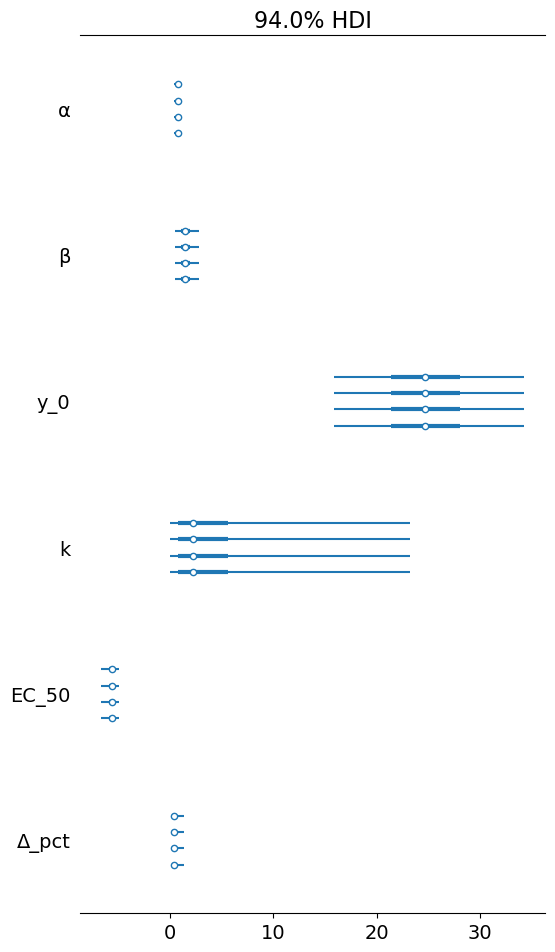

In [14]:
var_names = ['α', 'β', 'y_0', 'k', 'EC_50', 'Δ_pct']
ax = az.plot_forest(idata['sigmoid 4'][0], var_names=var_names)
fig = ax.ravel()[0].figure
attila_utils.savefig(fig, 'forest-plot-sigmoid-4')

In [15]:
az.summary(idata['sigmoid 4'][0], var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.745,0.187,0.410,1.096,0.005,0.004,1458.0,1957.0,1.0
β,1.573,0.729,0.438,2.764,0.020,0.015,1601.0,1565.0,1.0
y_0,24.812,4.949,15.899,34.268,0.123,0.087,1615.0,1383.0,1.0
k,13.973,93.817,0.003,23.209,2.390,1.690,2346.0,1461.0,1.0
EC_50,-5.716,0.445,-6.669,-4.988,0.009,0.007,2674.0,1675.0,1.0
Δ_pct,0.513,0.495,0.032,1.311,0.014,0.010,1191.0,1571.0,1.0


<AxesSubplot: xlabel='y / y'>

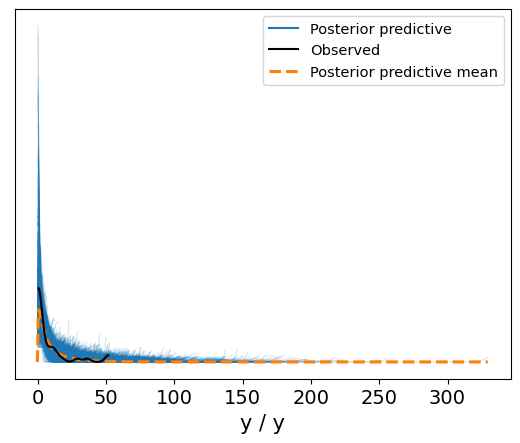

In [16]:
az.plot_ppc(posterior_samples['sigmoid 4'])

In [17]:
d = pd.DataFrame(posterior_samples[model].posterior_predictive['y'][0], columns=data_reshaped.conc_log10).unstack().to_frame('y')
d['conc_lg'] = d.index.get_level_values(0)
d

y  conc_lg
conc_log10                        
-5.0       0     9.114033     -5.0
           1    23.833329     -5.0
           2     0.766968     -5.0
           3     0.377689     -5.0
           4     4.720157     -5.0
...                   ...      ...
-9.0       995  18.231985     -9.0
           996   5.230658     -9.0
           997  22.806153     -9.0
           998  75.526639     -9.0
           999  32.318799     -9.0

[24000 rows x 2 columns]

['named-figure/posterior-predictive-sigmoid.png',
 'named-figure/posterior-predictive-sigmoid.pdf']

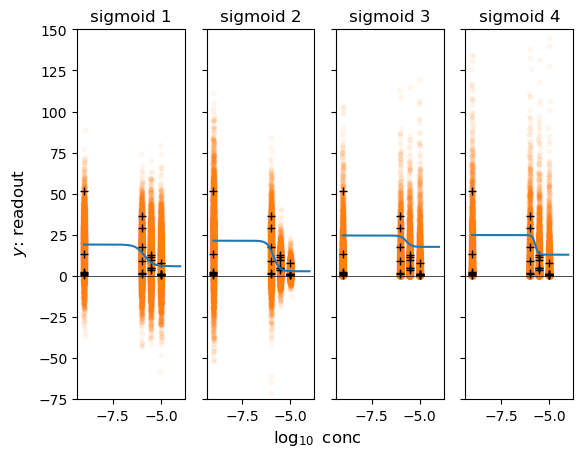

In [18]:
sigmoid_models = [s for s in idata.keys() if re.match('^sigmoid.*', s)]
fig, ax = plt.subplots(1, len(sigmoid_models), sharey=True)
for axi, model in zip(ax, sigmoid_models):
    ayy = posterior_samples[model].posterior_predictive['y'][0].transpose().to_numpy()
    axx = data_reshaped.conc_log10.to_numpy().repeat(ayy.shape[1])
    axx += 0.025 * scipy.stats.norm.rvs(size=len(axx))
    ayy = ayy.flatten()
    _ = axi.plot(axx, ayy, linewidth=0, marker='.', color='C1', alpha=0.05)
    _ = axi.plot(data_reshaped.conc_log10, posterior_samples[model].observed_data['y'], linewidth=0, marker='+', color='k', alpha=1)
    means = {k: v['data'] for k, v in idata[model][0].posterior.mean().to_dict()['data_vars'].items()}
    xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
    μ_mean = means['y_1'] + (means['y_0'] - means['y_1']) / (1 + np.exp(means['k'] * (xx - means['EC_50'])))
    axi.plot(xx, μ_mean)
    axi.axhline(0, color='k', linewidth=0.5)
    axi.set_title(model)
    axi.set_ylim(-75, 150)
fig.supxlabel('$\log_{10}$ conc')
fig.supylabel('$y$: readout')
attila_utils.savefig(fig, 'posterior-predictive-sigmoid')

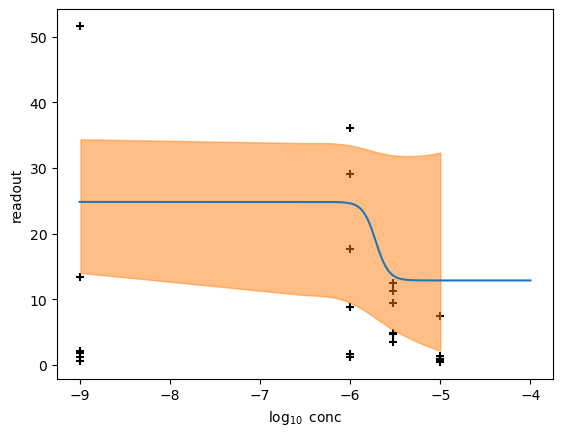

In [19]:
model = 'sigmoid 4'
fig, ax = plt.subplots()
ax = plot_data(ax)
xx = np.linspace(data_reshaped.conc_log10.min(), data_reshaped.conc_log10.max() + 1, 200)
az.plot_hdi(data_reshaped.conc_log10, idata[model][0].posterior['μ'], ax=ax)
means = {k: v['data'] for k, v in idata[model][0].posterior.mean().to_dict()['data_vars'].items()}
μ_mean = means['y_1'] + (means['y_0'] - means['y_1']) / (1 + np.exp(means['k'] * (xx - means['EC_50'])))
ax.plot(xx, μ_mean)

['named-figure/prior-posterior-curves-linear-1.png',
 'named-figure/prior-posterior-curves-linear-1.pdf']

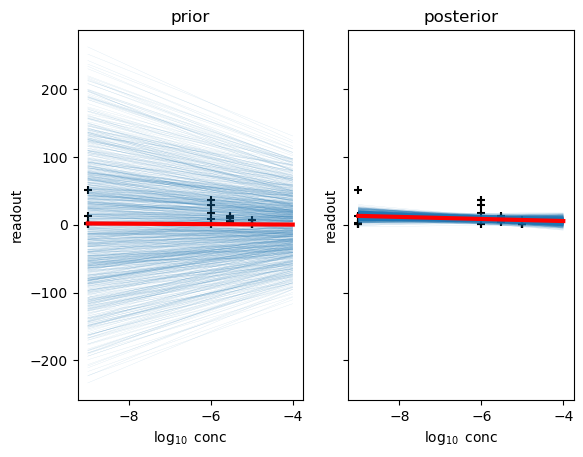

In [20]:
def prior_posterior_curves_linear_1():
    fig, ax = plt.subplots(1, 2, sharey=True)
    for axi, idat, prior_posterior in zip(ax, [prior_samples['linear 1'].prior, idata['linear 1'][0].posterior], ['prior', 'posterior']):
        axi = plot_data(axi)
        axi = plot_sampled_curves_linear_1(ax=axi, data=idat, alpha=0.2)
        axi.set_title(prior_posterior)
    return((fig, ax))

fig, ax = prior_posterior_curves_linear_1()
attila_utils.savefig(fig, 'prior-posterior-curves-linear-1')

['named-figure/prior-posterior-curves-linear-1-zoom.png',
 'named-figure/prior-posterior-curves-linear-1-zoom.pdf']

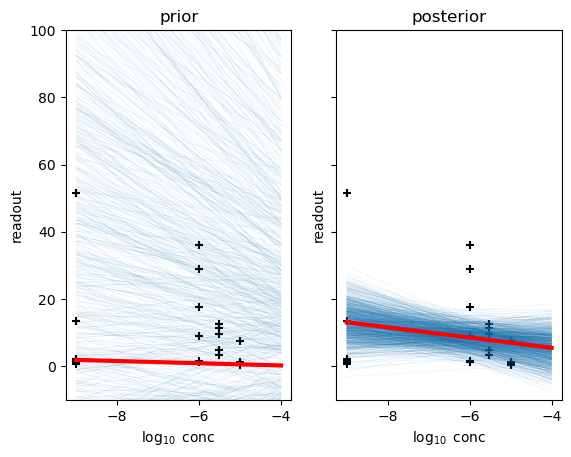

In [21]:
fig, ax = prior_posterior_curves_linear_1()
ax[1].set_ylim(-10, 100)
attila_utils.savefig(fig, 'prior-posterior-curves-linear-1-zoom')

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_14064/888990855.py:16: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_14064/888990855.py:16: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_14064/888990855.py:16: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_14064/888990855.py:16: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_14064/888990855.py:16: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_14064/888990855.py:16

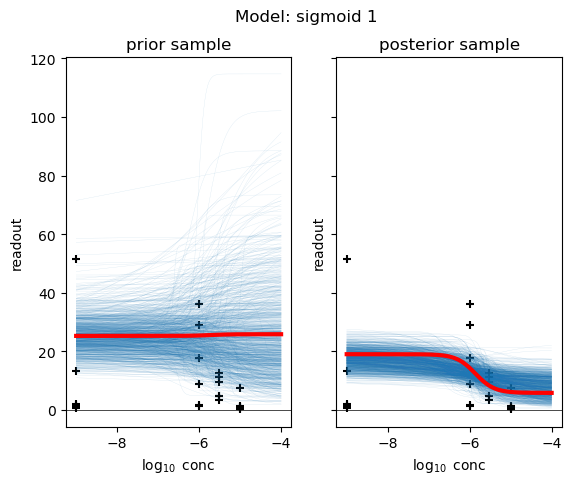

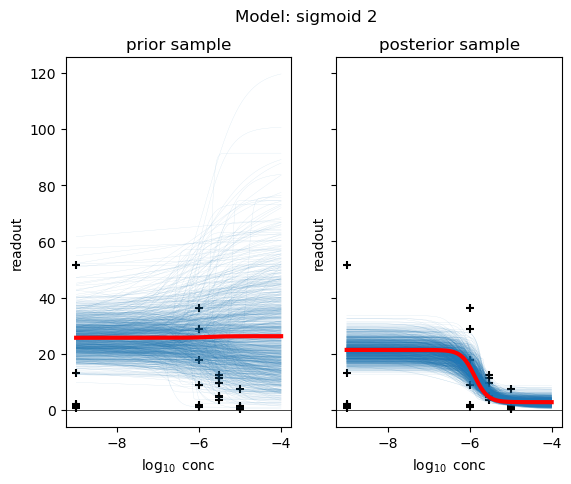

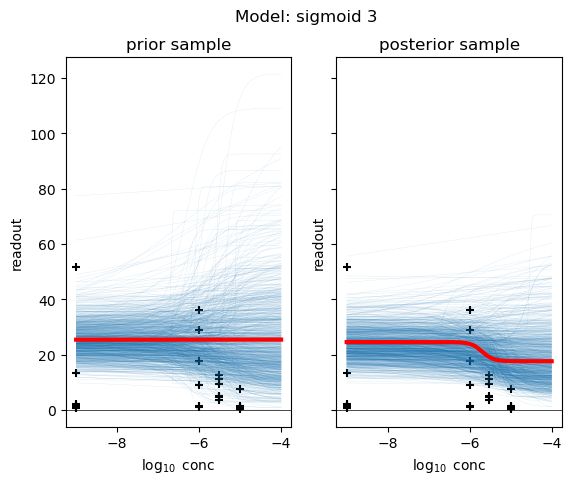

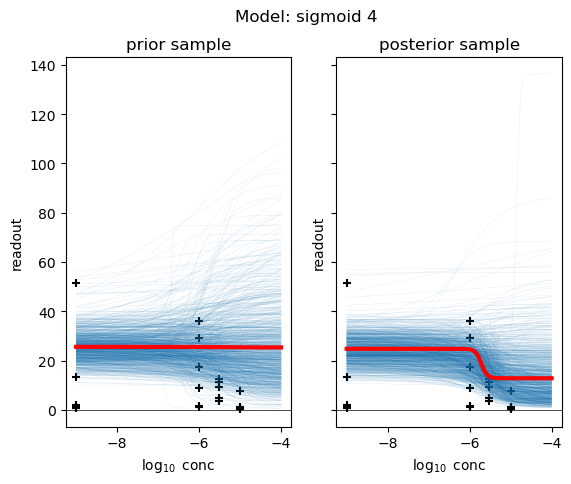

In [22]:
def prior_posterior_curves_sigmoid(model='sigmoid 1', prior_samples=prior_samples):
    prior = prior_samples[model].prior
    fig, ax = plt.subplots(1, 2, sharey=True)
    fig.suptitle('Model: ' + model)
    for axi, data, title in zip(ax, [prior, idata[model][0].posterior], ['prior sample', 'posterior sample']):
        axi = plot_data(axi)
        axi = plot_sampled_curves_sigmoid_1(ax=axi, data=data, alpha=0.2)
        axi.set_title(title)
        axi.axhline(0, color='k', linewidth=0.5)
    return((fig, ax))

for i, model in zip(range(len(sigmoid_models)), sigmoid_models):
    fig, ax = prior_posterior_curves_sigmoid(model=model, prior_samples=prior_samples)
    attila_utils.savefig(fig, 'prior-posterior-curves-sigmoid-' + str(i + 1))

['named-figure/mcmc-trace-sigmoid-4.png',
 'named-figure/mcmc-trace-sigmoid-4.pdf']

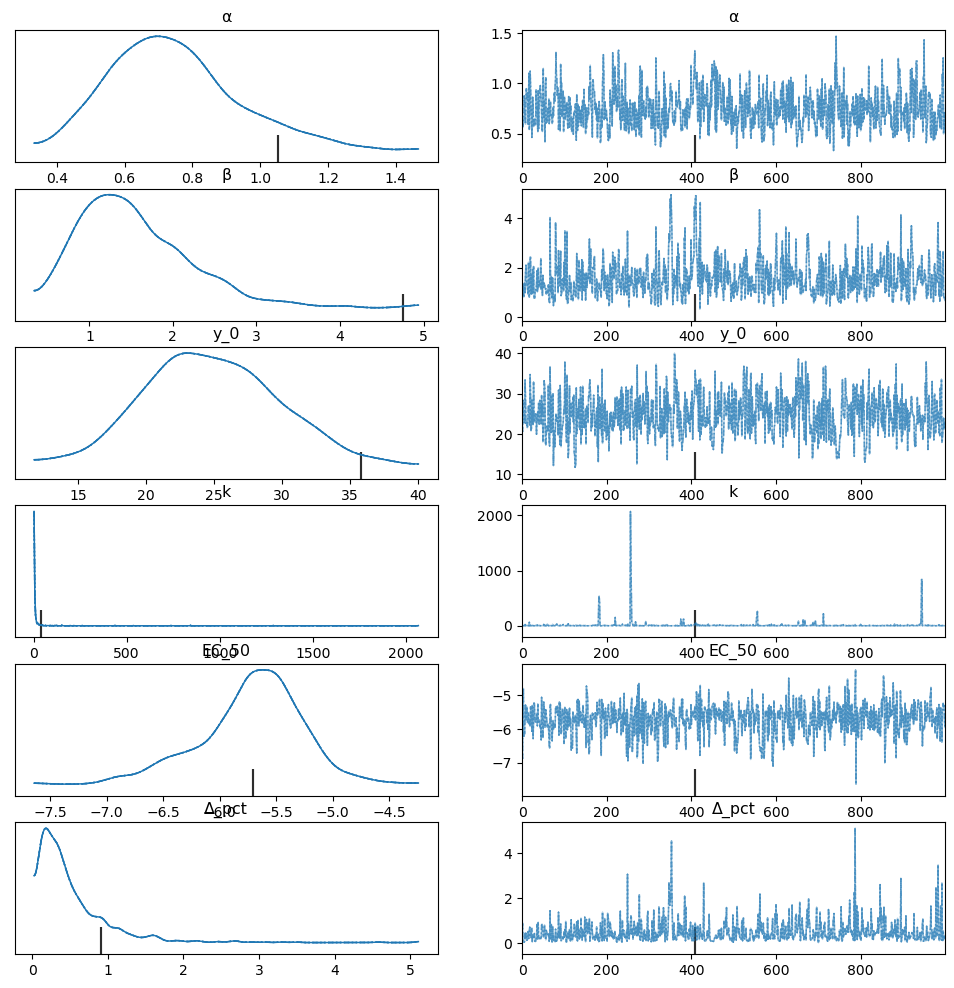

In [23]:
sel_mod = 'sigmoid 4'
ax = az.plot_trace(idata[sel_mod][0], var_names=var_names)
fig = ax.ravel()[0].figure
attila_utils.savefig(fig, 'mcmc-trace-' + sel_mod.replace(' ', '-'))

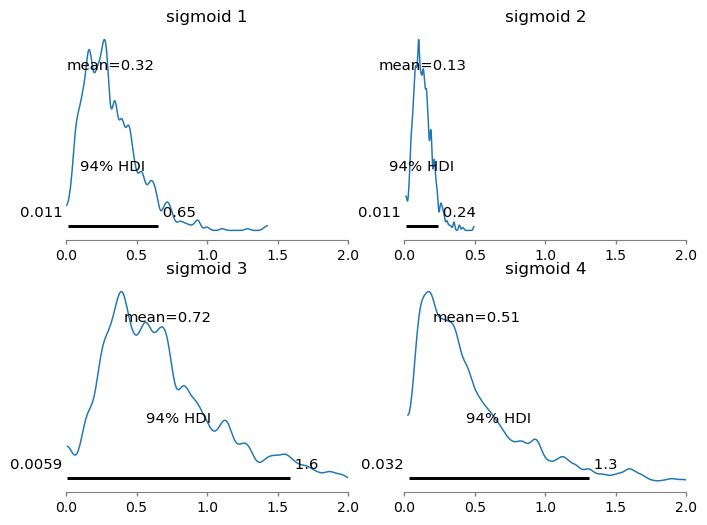

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
for axi, model in zip(ax.ravel(), sigmoid_models):
    az.plot_posterior(idata[model][0], var_names = ['Δ_pct'], ax=axi, textsize=10)
    axi.set_title(model)
    axi.set_xlim(0, 2)

In [25]:
%connect_info

{
  "shell_port": 60378,
  "iopub_port": 60379,
  "stdin_port": 60380,
  "control_port": 60382,
  "hb_port": 60381,
  "ip": "127.0.0.1",
  "key": "7e6e41dc-376e01d65dbc837a4b9d8adb",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-57cb3bb3-f7e6-4a41-9f4b-f2db9b08639b.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
